# Deep Hedging revisited

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# Set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set the seaborn plotting theme
sns.set_theme()
plt.rcParams["figure.figsize"] = (13,5)

Using device: cuda


### Examples of path generators

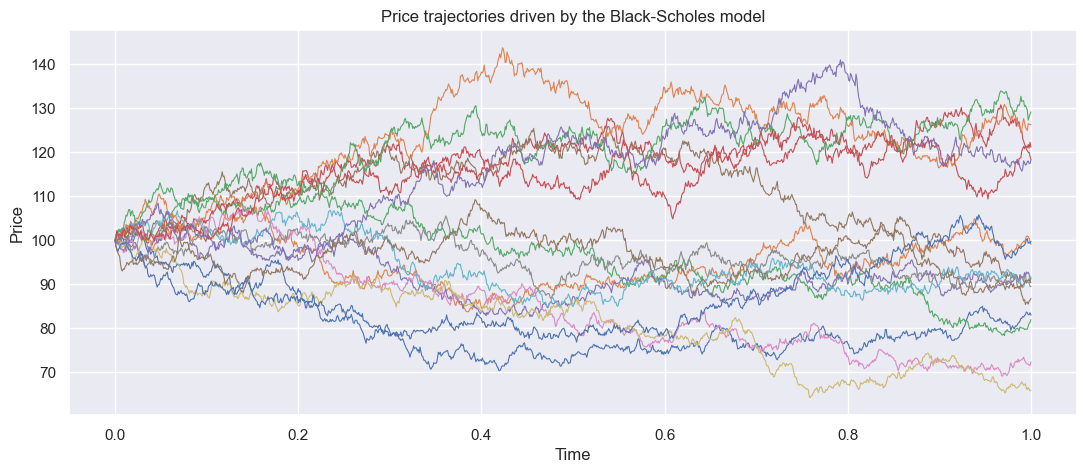

In [3]:
# The Black-Scholes model

from deephedging.generators import BlackScholesGenerator

# Set parameters
S0 = 100                # Initial stock price
r = 0.05                # Risk-free interest rate
sigma = 0.2             # Volatility
T = 1                   # Time horizon
N = 1000                # Number of time steps
batch_size = 16         # Number of paths in each batch
num_batches = 100       # Number of batches to generate

# Generate paths
BS_generator = BlackScholesGenerator(S0, r, sigma, T, N, batch_size,
                                     num_batches, DEVICE)
example_paths = next(BS_generator)

# Plot paths
plt.plot(np.linspace(0,1,num=N+1), example_paths.cpu().T, alpha=1, linewidth=0.8)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price trajectories driven by the Black-Scholes model")
plt.show()

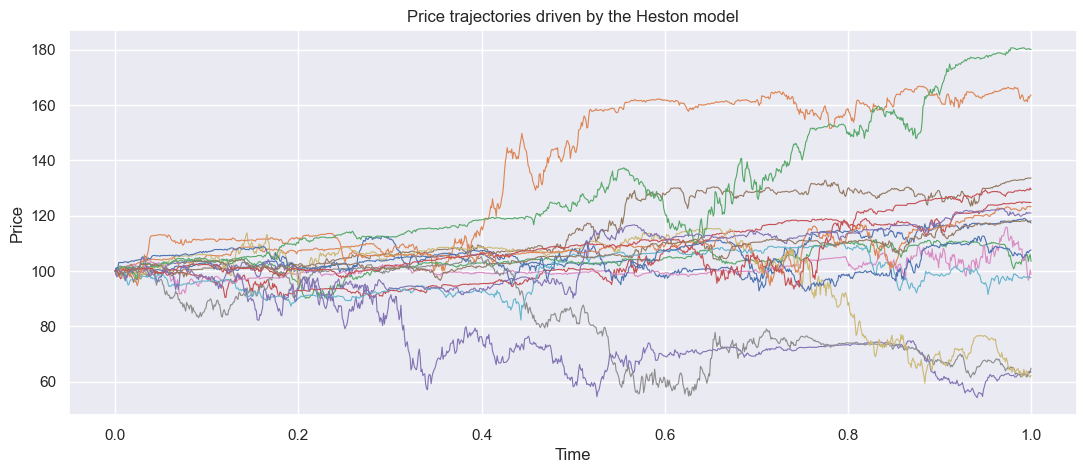

In [4]:
# The Heston stochastic volatility model

from deephedging.generators import HestonGenerator

# Set parameters
S0 = 100              # the initial asset price
v0 = 0.04             # the initial volatility
r = 0                 # the risk-free rate
theta = 0.04          # the long-term price variance
kappa = 1             # the rate of reversion to theta
xi = 2                # the volatility of sqrt(V_t)  
rho = -0.7            # the correlation of Brownian motions
T = 1                 # Time period
N = 1000              # Number of trading days
num_batches = 100     # Number of batches
batch_size = 16       # Number of paths in each batch

# Generate paths
Heston_generator = HestonGenerator(S0, v0, r, theta, kappa, xi, rho, T, N,
                                   batch_size, num_batches, DEVICE)
example_paths = next(Heston_generator)

# Plot paths
plt.plot(np.linspace(0,1,num=N+1), example_paths.cpu().T, alpha=1, linewidth=0.8)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price trajectories driven by the Heston model")
plt.show()

### Hedging in the Black-Scholes model

In [12]:
# Initialize the Black-Scholes path generator

# Set model parameters
S0 = 100                # Initial stock price
r = 0.05                # Risk-free interest rate
sigma = 0.2             # Volatility
T = 1                   # Time horizon
N = 1000                # Number of time steps
batch_size = 5000       # Number of paths in each batch
num_batches = 200       # Number of batches to generate

BS_generator = BlackScholesGenerator(S0, r, sigma, T, N, batch_size,
                                     num_batches, DEVICE)

200it [02:09,  1.54it/s]


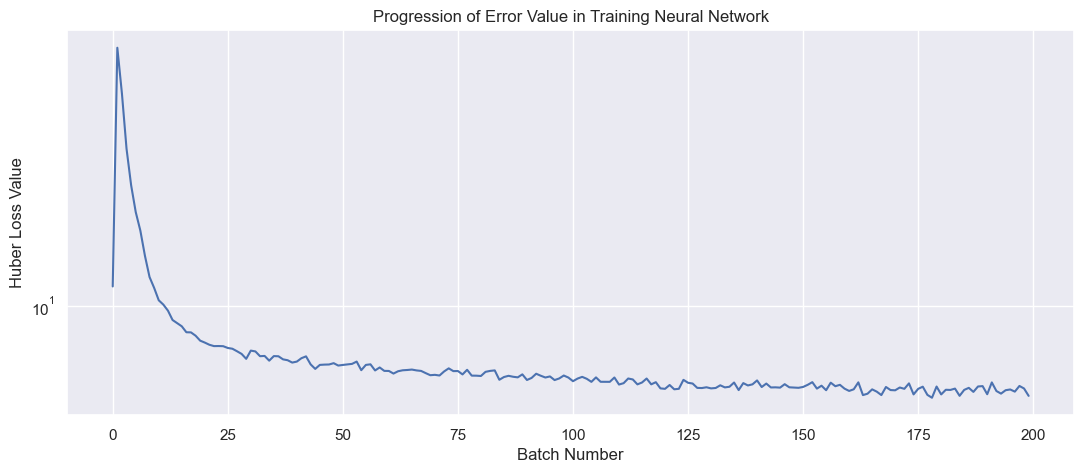

In [13]:
from deephedging.hedging import FeedForwardHedgingStrategy
from deephedging.option_pricing import get_european_call_price

# Parameters for the neural network (hedging strategy)
hidden_nodes = 100    # Number of hidden nodes in the neural network
lr = 0.05             # Learning rate

# Initialize the hedging strategy
errors = []
loss = nn.HuberLoss()
strategy = FeedForwardHedgingStrategy(hidden_nodes, N).to(DEVICE)
optimizer = optim.Adam(strategy.parameters(), lr=lr)

# Train the hedging neural networks
for S in tqdm(BS_generator):
    optimizer.zero_grad()
    error = loss(strategy(S)[0], get_european_call_price(S[:,-1], S0))
    errors.append(error.item())
    error.backward()
    optimizer.step()

# Plot the evolution of the error value
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(errors))
plt.xlabel("Batch Number")
plt.ylabel("Huber Loss Value")
plt.title("Progression of Error Value in Training Neural Network")
plt.show()

In [14]:
from deephedging.option_pricing import BlackScholesCallOption
S = S.cpu() # Convert to allow numpy operations

# Initialize the arrays containing the times to maturity for each path
times_to_maturity = np.linspace(T, 0, N + 1) 
times_to_maturity[-1] = 10**(-6) # Avoid division by zero
time_paths = np.matlib.repmat(times_to_maturity, 5000, 1)

# Compute the delta of the BS call option and the initial price for each path
# print(type(S.cpu()))
BS_delta = BlackScholesCallOption(S, S0, r, 0, time_paths, sigma).get_delta()
BS_init_price = BlackScholesCallOption(S[:,0], S0, r, 0, T, sigma).get_price()

# Compute the Black-Scholes delta hedging terminal values for each path
dS = np.diff(S, axis=1)
BS_hedging_value = BS_init_price.detach().numpy() + np.sum(dS * BS_delta[:,:-1], axis=1)

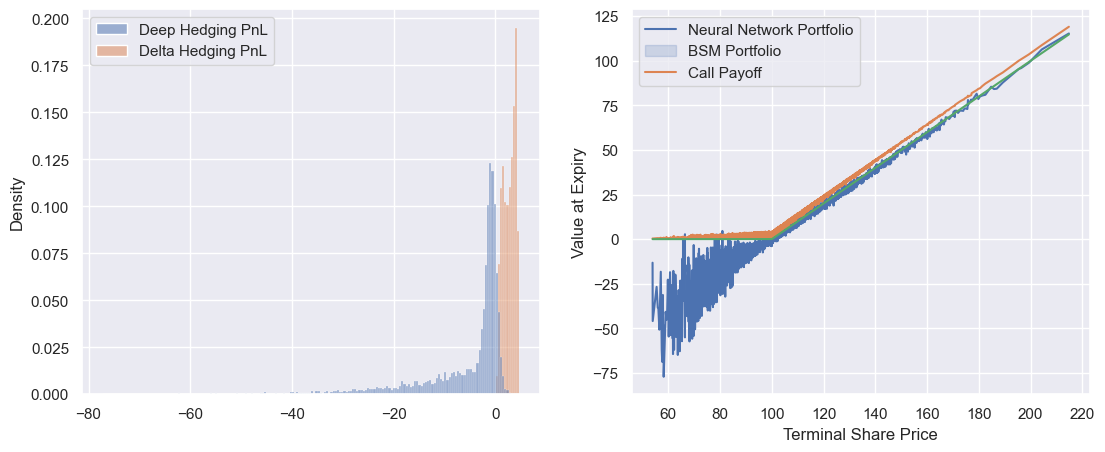

In [15]:
# Compute the deep hedging and delta hedging pnl for each path
hedge = strategy(S.to(DEVICE))
BS_call_prices = get_european_call_price(S[:,-1], S0).detach().numpy()
deephedging_pnl = hedge[0].cpu().detach().numpy() - BS_call_prices
BS_pnl = BS_hedging_value - BS_call_prices
pnl = pd.DataFrame([deephedging_pnl, BS_pnl]).transpose()
pnl.columns = ["Deep Hedging PnL", "Delta Hedging PnL"]

# Get the terminal payoffs
hedging_payoffs = pd.DataFrame([S[:,-1],
                               hedge[0],
                               BS_hedging_value,
                               BS_call_prices]).transpose()
hedging_payoffs.columns = ["Terminal Prices", "Deep Hedging Values",
                           "Delta Hedging Value", "Call payoffs"]


# Plot the PnLs and terminal prices 
fig, ax = plt.subplots(1,2)
with torch.no_grad():
    sns.histplot(pnl, stat = 'density', ax = ax[0])
    plt.xlabel('Terminal Share Price')
    plt.ylabel('Value at Expiry')
    sns.lineplot(x = S[:, -1], y = hedge[0].cpu(), ax=ax[1])
    sns.lineplot(x = S[:, -1], y = BS_hedging_value, ax=ax[1])
    sns.lineplot(x = S[:, -1], y = BS_call_prices, ax=ax[1])
    plt.legend(labels = ['Neural Network Portfolio', 'BSM Portfolio', 'Call Payoff'])
plt.show()

In [16]:
# Compute the mean and variance of the PnLs
print("Mean PnL: \n", pnl.mean(), "\n")
print("Variance of PnL:", "\n", pnl.var())

Mean PnL: 
 Deep Hedging PnL    -5.768937
Delta Hedging PnL    2.742396
dtype: float64 

Variance of PnL: 
 Deep Hedging PnL     83.262384
Delta Hedging PnL     1.388695
dtype: float64
